# Microcanonical Molecular Dynamics Simulation
Velocity Verlet Algorithm; created 07/09/24

#### References
- D. Frenkel and B. Smit, *Understanding Molecular Simulation*, Academic Press, 2002.
- [Intro to Molecular Dynamics: Coding MD From Scratch](https://youtu.be/ChQbBqndwIA?si=d8QpMox3vhjQYxJm): Helpful for laying out the steps intuitively
- [Stack Overflow](https://stackoverflow.com/questions/70014001/make-elements-with-value-division-by-zero-equal-to-zero-in-a-2d-numpy-array): For division by 0 in 2D arrays

In [ ]:
"""

Work In Progress

- Better visualisation
- Fix energy conservation
- Fix notes on formulas - not updated
- Documentation

"""

#### Goals:
- Implement a molecular dynamics simulation (velocity Verlet Algorithm) using the Lennard-Jones potential.
- Include periodic boundary conditions as well as the minimum image convention. 
- Create an animation visualising the particles.
- Simulate a bulk liquid, and create a figure of the radial distribution function.

#### Additional goals:
- Testing with other algorithms (e.g. Leap Frog) and ensembles.
- Testing with molecules and including other force field terms.
- Compute other thermodynamic properties: temperature, pressure, heat capacity (Ch 4.4 F&S).
- Calculate statistical error (pg 98 F&S).
- Parallelisation

## Libraries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
#from matplotlib.animation import FuncAnimation
#from mpl_toolkits import mplot3d
#import pylab as pl
#from IPython import display

## Initial Parameters

In [15]:
# Particle Parameters
m = 1 # Mass of particles, u
eps = 1 #epsilon
sig = 1 #sigma

# Initial Parameters
steps = 2500 # Time steps
N = 3 # Number of particles
L = 5 # Side of box, Angstroms
rc = 2.5*sig #Cut off radius for interactions
dt = 0.01 # ps
T = 0.728 # Initial Temperature, K

# Constants
#kb_SI = 1.380649*10**(-23) #J K−1 or 8.617333262*10**(-5) eV K-1; Boltzmann's constant
#avo = 6.02217364335*10**(26) # Multiply kg to get mass in u
#kb = kb_SI*avo*10**(-4) # Boltzmann constant in u A^2 ps^-2 K-1
kb = 1


## Functions
- length: Distance between two particles taking into account the minimum image convention.
- LJ: Potential energy of a particle as a sum of its pair-wise Lennard-Jones interactions.
- force: Components of force due to Lennard-Jones interactions.
- update: Updates the position, velocity, and acceleration of each particle after a single time step.
- energy: Returns the energy of the system as the sum of potential energy (LJ) and kinetic energy.

In [16]:
def length(position):
    """
    Returns the distance r_ij of closest images between each pair of particles as an N X N matrix.

    Parameters
    ----------
    position: ndarray of floats, N x 3
        x, y, z coordinates of each particle.
    
    Returns
    -------
    ndarray of floats, N x N
        Distance between particles as a matrix Y, where Y[1,2] is the closest image distance between particle 1 and 2.
    """

    Y = np.zeros((N, N))
    diff = np.zeros((N, N, 3))

    for i in range(N):
        diff[i] = position[i] - position #diff[i] is the difference in x/y/z coords of particle i to all other particles
        diff[i] = diff[i] - L*np.round(diff[i]/L, decimals=0) # difference between nearest image
        Y[i] = np.linalg.norm(diff[i], axis=1)

    return diff, Y


In [17]:
#Energy and force using Lennard-Jones

def LJ(epsilon, sigma, position):
    """
    Returns the total Lennard-Jones potential energy of the system.
    
    Parameters
    ----------
    epsilon: float
        Well depth.
    
    sigma: float
        Distance at which potential energy is zero.
    
    position: ndarray of floats, N x 3
        Position of each particle.
    
    Returns
    -------
    ndarry of floats, N x 1
        Total potential energy of each particle.
    """

    LJ_array = np.zeros((N,3))
    coord, dist = length(position)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        a = (sigma/dist)**12
        b = (sigma/dist)**6
        LJ_array = 4*epsilon*(a - b)
        LJ_array[LJ_array == np.inf] = 0
        LJ_array = np.nan_to_num(LJ_array)

    return np.sum(LJ_array)


def force(epsilon, sigma, position):
    """
    Returns the force due to the Lennard-Jones potential of each particle.
    
    Parameters
    ----------
    epsilon: float
        Well depth.
    
    sigma: float
        Distance at which potential energy is zero.
    
    position: ndarray of floats, N x 3
        Position of each particle.
    
    Returns
    -------
    ndarray of floats, N x 3
        x, y, z component of force on each particle as a result of the pair-wise interactions.
    """

    force_array = np.zeros((N,N,3))
    a1, a2 = length(position)

    for i in range(N):
        for j in range(N):
            coord = a1[i,j]
            dist = a2[i][j]
            if abs(dist) < rc:
                with np.errstate(divide='ignore', invalid='ignore'):
                    a = (sigma/dist)**12
                    b = (sigma/dist)**6
                    force_array[i][j] = ((48*epsilon*coord)/(dist**2))*(a - 0.5*b)
                    force_array[i][j][force_array[i][j] == np.inf] = 0
                    force_array[i][j] = np.nan_to_num(force_array[i][j])
    
    force_array = np.sum(force_array, axis=1)

    return force_array

In [18]:
def update(position, velocity, acceleration, delta):
    """
    Returns the updated positions, velocities, and accelerations of the particles after one time step.
    
    Parameters
    ----------
    position: ndarray of floats, N x 3
        x, y, z coordinates of each particle.

    velocity: ndarray of floats, N x 3
        x, y, z component of velocity of each particle.

    acceleration: ndarray of floats, N x 3
        x, y, z coordinates of each particle.
    
    Returns
    -------
    ndarray of 3 ndarrys of floats
        Updated arrays of position, velocity, and acceleration of each particle.
    """
    new_r = (position + delta*velocity + 0.5*acceleration*delta**2) % L
    new_a = force(eps, sig, new_r)/m
    new_v = velocity + 0.5*delta*(acceleration + new_a)
    return new_r, new_v, new_a

In [19]:
def energy(epsilon, sigma, position, velocity):
    """
    Returns the energy of the system (potential, kinetic).

    Parameters
    ----------
    epsilon: float
        Well depth.
    
    sigma: float
        Distance at which potential energy is zero.
    
    position: ndarray of floats, N x 3
        Position of each particle.

    velocity: ndarray of floats, N x 3
        x, y, z component of velocity of each particle.
    
    Returns
    -------
    float
        Total energy of the system.
    """
    
    pot = LJ(epsilon, sigma, position)
    kin = 0.5*m*np.sum(velocity**2)
    
    return pot, kin

## Initialisation

In [22]:
#Initial conditions

r = L*np.random.rand(N, 3) # Randomised initial positions of particles in 3 dimensions; A
v = np.random.rand(N, 3) - 0.5 #Random velocities between -0.5 and 0.5; A per ps

"""""
r = np.array([[1.92980939, 8.75336178, 0.98531132],
 [7.16292344, 7.21891229, 8.33883334],
 [3.24033849, 1.46046646, 9.32454462]])
v = np.array([[ 0.1033227,  -0.19082324, -0.48751398],
 [ 0.05688305,  0.15399148,  0.15434149],
 [ 0.06619302,  0.39067774, -0.44718358]])

 """

a = force(eps, sig, r)/m # Initial acceleration

r0 = r

In [23]:
print(r)
print(v)
print(a)

[[0.48832705 1.78227969 1.55577346]
 [0.35094346 0.39984816 0.56097783]
 [1.23472458 2.08696843 0.06071666]]
[[ 0.24060374  0.04507533 -0.07240921]
 [-0.34636954  0.27379711  0.19159605]
 [-0.10383629 -0.10042612 -0.45178481]]
[[ 0.19527053 -0.32317836 -0.77689988]
 [ 0.13232529  0.59286732  0.25089744]
 [-0.32759582 -0.26968896  0.52600244]]


In [24]:
# Scaling velocities to initial temperature

v_com = np.sum(v,axis=0)/N # velocity centre of mass
v = v - v_com

U, KE = energy(eps, sig, r, v)

temp = 2*KE/(3*N*kb) # Instantaneous T of system; F&S Eq 4.2.2; Factor of 2 is due to KE being 0.5 mv^2
sf = np.sqrt(T/temp)

v = sf*v # Sets centre of mass to be 0, and scales v to be that of set temp.

In [26]:
print(v)
print(np.dot(v,v))

[[ 1.17898021 -0.10534003  0.14603543]
 [-1.04998692  0.76320601  1.14856666]
 [-0.12899329 -0.65786597 -1.29460209]]
[[ 1.48176241 -0.3006617  -0.13787494]
 [-2.18742752 -0.06251386 -0.76367911]
 [ 0.70566511  0.36317556  0.90155406]]


Progress: 99.96%

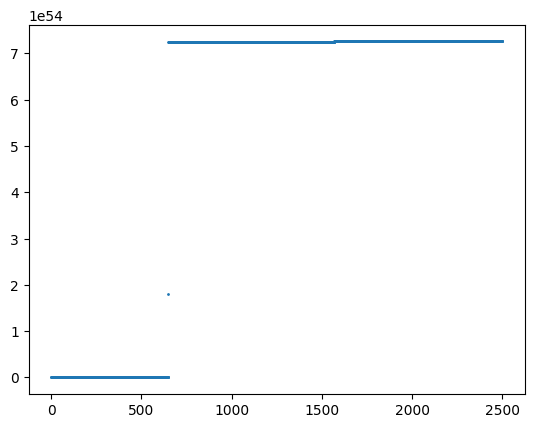

In [14]:
kinetic = np.empty((steps))

for i in range(steps):
        U, kinetic[i] = energy(eps, sig, r, v)
        r, v, a = update(r,v,a,dt)
        sys.stdout.write('\r')
        sys.stdout.write("Progress: {:.2%}".format(i/steps))
        sys.stdout.flush()

plt.scatter(np.arange(steps), kinetic/N, label="KE", s=1)
plt.show()

Progress: 99.96%

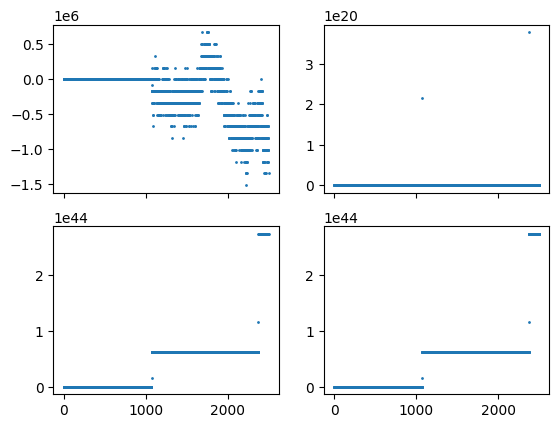

In [52]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=False)
axs = axs.ravel()

sumv = np.empty((steps)) # velocity of centre of mass
kinetic = np.empty((steps))
potential = np.empty((steps))
E = np.empty((steps))
run = 1

if run==1:
    for i in range(steps):
        sumv[i] = np.sum(v)/N
        potential[i], kinetic[i] = energy(eps, sig, r, v)
        r, v, a = update(r,v,a,dt)
        sys.stdout.write('\r')
        sys.stdout.write("Progress: {:.2%}".format(i/steps))
        sys.stdout.flush()

E = kinetic + potential

axs[0].scatter(np.arange(steps), sumv,s=1)
axs[1].scatter(np.arange(steps), potential/N, label = "U", s=1)
axs[2].scatter(np.arange(steps), kinetic/N, label="KE", s=1)
axs[3].scatter(np.arange(steps), E/N, label="Etot", s=1)
#plt.legend()

#plt.xscale("log")
#plt.xscale("log")
#plt.ylim(-0.01,0.01)
plt.show()

## Visualisation
- 3D and 2D visualisation
- Produce data files for OVITO visualisation - more time efficient.

In [91]:
# 3D Visualisation
""""
fig = plt.figure()
for i in range(steps):
    r = update(r,v,a)[0]
    v = update(r,v,a)[1]
    a = update(r,v,a)[2]
    ax = plt.axes(projection="3d")
    ax.set_xlim3d(0, L)
    ax.set_ylim3d(0, L)
    ax.set_zlim3d(0, L)
    ax.scatter3D([x[0] for x in r],[y[1] for y in r], [z[2] for z in r], s=10)
    display.clear_output(wait=True)
    display.display(pl.gcf())

"""

'"\nfig = plt.figure()\nfor i in range(steps):\n    r = update(r,v,a)[0]\n    v = update(r,v,a)[1]\n    a = update(r,v,a)[2]\n    ax = plt.axes(projection="3d")\n    ax.set_xlim3d(0, L)\n    ax.set_ylim3d(0, L)\n    ax.set_zlim3d(0, L)\n    ax.scatter3D([x[0] for x in r],[y[1] for y in r], [z[2] for z in r], s=10)\n    display.clear_output(wait=True)\n    display.display(pl.gcf())\n\n'

TypeError: update() missing 1 required positional argument: 'delta'

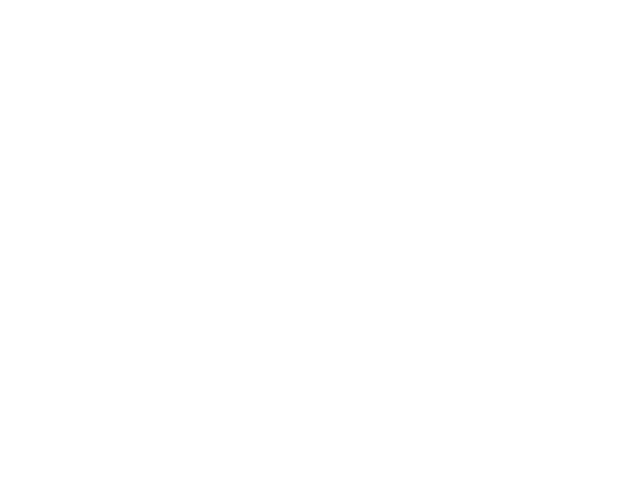

In [92]:
#2D Visualisation

fig = plt.figure()

for i in range(steps):
    r = update(r,v,a)[0]
    v = update(r,v,a)[1]
    a = update(r,v,a)[2]
    plt.scatter([x[0] for x in r],[y[1] for y in r], alpha=i/(5*steps), c="black")

plt.xlim(0, L)
plt.ylim(0, L)
plt.xlabel("x")
plt.ylabel("y")

TypeError: update() missing 1 required positional argument: 'delta'

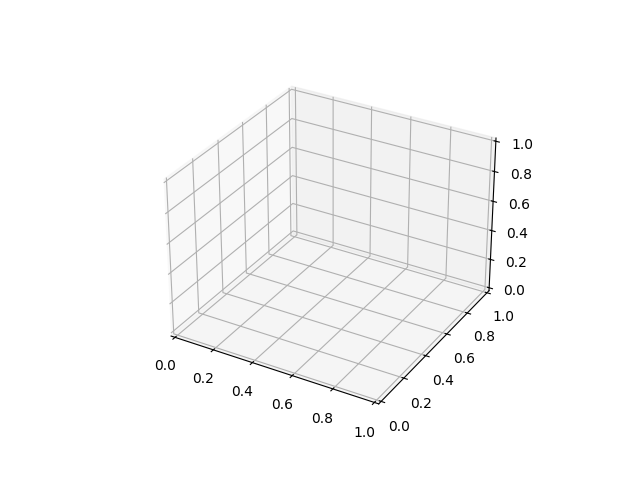

In [93]:
# Rotatable 3D scatter plot

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(steps):
    r = update(r,v,a)[0]
    v = update(r,v,a)[1]
    a = update(r,v,a)[2]
    ax.scatter([x[0] for x in r],[y[1] for y in r], [z[2] for z in r], alpha=i/(10*steps), c="black")

#### OVITO
Visualisation software. Code below creates a directory named "dumps" which stores the data files generated.
- molecule labels: atoms are named from 0 to N-1.
- types: the colour it appears as (group).
- dump function: generates data file as t*.dump

In [94]:
#Print files for OVITO

outdir="dumps"
try: #make directory if it does not exist
    os.mkdir(outdir)
except:
    pass

#Types in groups of three
tp=[0]*N
for i in range(int(N/3)):
    tp[3*i]=0
    tp[3*i+1]=0
    tp[3*i+2]=0

#dump
def dump(r,t):
    fname=outdir+"/t"+str(t)+".dump"
    f=open(fname,"w")
    f.write("ITEM: TIMESTEP\n")
    f.write(str(t)+"\n") #time step
    f.write("ITEM: NUMBER OF ATOMS\n")
    f.write(str(len(r))+"\n") # number of atoms
    f.write("ITEM: BOX BOUNDS pp pp pp\n") #pp = periodic BCs
    f.write("0 "+str(L)+"\n")
    f.write("0 "+str(L)+"\n")
    f.write("0 "+str(L)+"\n")
    f.write("ITEM: ATOMS id x y z\n")
    for i in range(len(r)):
        f.write(str(i)+" "+str(r[i][0])+" "+str(r[i][1])+" "+str(r[i][2])+"\n")
    f.close